# Wild Flower Classification Project 3 - season2 Last 5 blocks

### Wild Flower Classification using Transfer Learning 3 season2 - Last 5 blocks

This is taken from `wildflower_classifier3.ipynb` for season 2 (Refined data version)

- Using InceptionV3 + `tf.keras.applications.inception_v3.preprocess_input` instead of `rescale = 1./255`
- weight decay : 0.0001 -> 0.00001  ===> Same weight decay as classifier2. (= 0.0001)
- **Fine tune last 5 Inception Modules**

In [1]:
import os
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
%matplotlib notebook
%load_ext tensorboard

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
#from tensorflow.keras.preprocessing import image_dataset_from_directory # cant import in Tensorflow v2.2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.regularizers import l2
from tensorflow.keras import losses
from tensorflow.keras import optimizers

import matplotlib.pyplot as plt
import numpy as np
import random
from numpy.random import default_rng

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.2.0


In [3]:
#from centerLoss import prelu, zero_loss, my_model
#from centerLoss import CenterLossLayer
#from utils import tbProjector, PCAPlotter, create_testdata

In [4]:
#tf.test.is_gpu_available()
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
tf.config.list_physical_devices('CPU')

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

## Counting Training Data 

In [6]:
image_dir = "wf_data2"
train_dir = os.path.join(image_dir, "train")
print(train_dir)

train_classnum = len(os.listdir(train_dir))
print("items = {}".format(len(os.listdir(train_dir))))

wf_data2/train
items = 108


In [7]:
all_images = 0
class_list = sorted(os.listdir(train_dir))
for i in class_list:
    #print(i)
    all_images += len(os.listdir(os.path.join(train_dir, i)))
print("All image files = {}".format(all_images))
print("class_list[:10] = {}".format(class_list[:10]))

All image files = 4853
class_list[:10] = ['Actinotus_helianthi', 'Alyogyne_huegelii', 'Anthocercis_littorea', 'Anthocercis_viscosa', 'Banksia', 'Beaufortia_squarrosa', 'Blandfordia_grandiflora', 'Bossiaea_aquifolium_', 'Bossiaea_eriocarpa', 'Burchardia_congesta']


In [8]:
_BATCH_SIZE = 32

## Inspect training dataset

In [9]:
def plot_dataset(image_samples, name_list):

    #plt.figure(figsize=(5, 2))
    fig, axs = plt.subplots(len(image_samples)//5, 5, figsize=(9, 5) )
                            
    count = 0
    for i in range(len(image_samples)//5):
        for j in range(5):
 
            img = tf.keras.preprocessing.image.load_img(image_samples[count])
            img = tf.keras.preprocessing.image.img_to_array(img)
            img /= 255.
            axs[i, j].imshow(img)
            axs[i, j].set_xticks([])
            axs[i, j].set_yticks([])
            axs[i, j].set_title(name_list[count], fontdict={'fontsize' : 'small'})
            count+=1
        #plt.title(examples[1][i])
    plt.show()

<IPython.core.display.Javascript object>


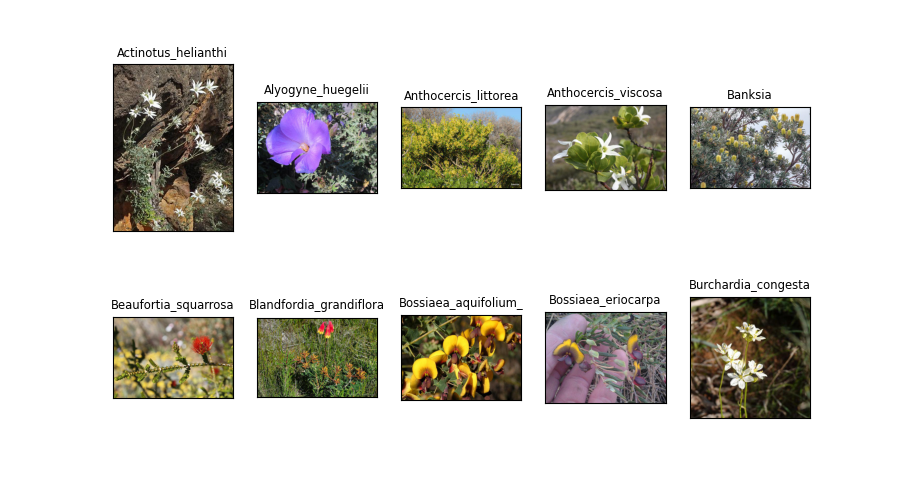

In [10]:
show_plot_num = 10

plot_list = []
for i, cls in enumerate(class_list):
    if i >= show_plot_num:
        break
        
    cls_path = os.path.join(train_dir, cls)
    imlist = os.listdir(cls_path)
    plot_list.append(os.path.join(cls_path, imlist[0]))
    
#print(plot_list)
#print(class_list[:show_plot_num])
plot_dataset(plot_list, class_list[:show_plot_num])

## Setup train data generator

In [11]:
train_datagen = ImageDataGenerator(
    shear_range=0.1,
    #zoom_range=0.1,
    rotation_range=20,
    horizontal_flip=True,   
    #rescale=1./255
    preprocessing_function=keras.applications.inception_v3.preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=_BATCH_SIZE,
    class_mode='categorical'
    ) 

Found 4853 images belonging to 108 classes.


## Setup validation data generator

In [12]:
valid_dir = os.path.join(image_dir, "valid")

all_images_valid = 0

for cl in class_list:
    all_images_valid += len(os.listdir(os.path.join(valid_dir, cl)))

print("All image files in validation = {}".format(all_images_valid))
#print("class_list[:10] = {}".format(class_list[:10]))

All image files in validation = 605


In [13]:
#valid_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(preprocessing_function=keras.applications.inception_v3.preprocess_input)

valid_generator = valid_datagen.flow_from_directory(
    os.path.join(image_dir, "valid"),
    target_size=(224, 224),
    batch_size=_BATCH_SIZE,
    class_mode='categorical'
    ) 

Found 605 images belonging to 108 classes.


## Load a pre-trained model and attach some fully-connected layers

In [14]:
weight_decay = 0.0001

img_input = keras.Input(shape=(224, 224, 3))
train_labels = keras.Input(shape=(train_classnum,))

base_model = keras.applications.InceptionV3(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False

#x = base_model(img_input, training=False)
x = base_model(img_input)
#x = keras.layers.Flatten()(x)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(256, activation='relu')(x)
#x = keras.layers.Dropout(0.5)(x)
out = keras.layers.Dense(train_classnum, activation='softmax', name='output', kernel_regularizer=l2(weight_decay))(x)
#out = keras.layers.Dense(train_classnum, activation='softmax', name='output')(x)

model = keras.Model(inputs=img_input, outputs=out)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328

## compile

In [15]:
#initial_learning_rate = 0.001

optim = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optim,
                  loss=losses.categorical_crossentropy,
                  metrics=['accuracy'])

In [16]:
epochs = 100
steps_per_epoch = int(all_images/_BATCH_SIZE)
val_steps = int(all_images_valid/_BATCH_SIZE)

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=valid_generator,
    validation_steps=val_steps
)

Epoch 1/100
151/151 [==============================] - 49s 328ms/step - loss: 4.6209 - accuracy: 0.0288 - val_loss: 3.9575 - val_accuracy: 0.1233
Epoch 2/100
151/151 [==============================] - 48s 321ms/step - loss: 3.8104 - accuracy: 0.1008 - val_loss: 3.1585 - val_accuracy: 0.2274
Epoch 3/100
151/151 [==============================] - 49s 321ms/step - loss: 3.3013 - accuracy: 0.1753 - val_loss: 2.8430 - val_accuracy: 0.2778
Epoch 4/100
151/151 [==============================] - 49s 323ms/step - loss: 3.0186 - accuracy: 0.2284 - val_loss: 2.5665 - val_accuracy: 0.3385
Epoch 5/100
151/151 [==============================] - 49s 321ms/step - loss: 2.8644 - accuracy: 0.2628 - val_loss: 2.4329 - val_accuracy: 0.3611
Epoch 6/100
151/151 [==============================] - 49s 322ms/step - loss: 2.7161 - accuracy: 0.2912 - val_loss: 2.3246 - val_accuracy: 0.3924
Epoch 7/100
151/151 [==============================] - 49s 322ms/step - loss: 2.6589 - accuracy: 0.2950 - val_loss: 2.2762 -

Epoch 57/100
151/151 [==============================] - 48s 321ms/step - loss: 1.7898 - accuracy: 0.5034 - val_loss: 1.7455 - val_accuracy: 0.5278
Epoch 58/100
151/151 [==============================] - 48s 320ms/step - loss: 1.7946 - accuracy: 0.4957 - val_loss: 1.7387 - val_accuracy: 0.5174
Epoch 59/100
151/151 [==============================] - 48s 321ms/step - loss: 1.8119 - accuracy: 0.4939 - val_loss: 1.7724 - val_accuracy: 0.5104
Epoch 60/100
151/151 [==============================] - 48s 321ms/step - loss: 1.7723 - accuracy: 0.5130 - val_loss: 1.7575 - val_accuracy: 0.5365
Epoch 61/100
151/151 [==============================] - 48s 321ms/step - loss: 1.7243 - accuracy: 0.5184 - val_loss: 1.7299 - val_accuracy: 0.5399
Epoch 62/100
151/151 [==============================] - 48s 321ms/step - loss: 1.7625 - accuracy: 0.5074 - val_loss: 1.7278 - val_accuracy: 0.5312
Epoch 63/100
151/151 [==============================] - 48s 321ms/step - loss: 1.7920 - accuracy: 0.5082 - val_loss: 1

In [17]:
#model_file = "wfmodel_noft_" + str(epoch_time) + ".h5"
model_file = "wfmodel3_s2_5b_noft" + ".h5"
model.save(model_file)
print("Trained model was saved into {}.".format(model_file))

Trained model was saved into wfmodel3_s2_5b_noft.h5.


## Fine Tuning

In [18]:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name, layer.trainable)

0 input_3 False
1 conv2d False
2 batch_normalization False
3 activation False
4 conv2d_1 False
5 batch_normalization_1 False
6 activation_1 False
7 conv2d_2 False
8 batch_normalization_2 False
9 activation_2 False
10 max_pooling2d False
11 conv2d_3 False
12 batch_normalization_3 False
13 activation_3 False
14 conv2d_4 False
15 batch_normalization_4 False
16 activation_4 False
17 max_pooling2d_1 False
18 conv2d_8 False
19 batch_normalization_8 False
20 activation_8 False
21 conv2d_6 False
22 conv2d_9 False
23 batch_normalization_6 False
24 batch_normalization_9 False
25 activation_6 False
26 activation_9 False
27 average_pooling2d False
28 conv2d_5 False
29 conv2d_7 False
30 conv2d_10 False
31 conv2d_11 False
32 batch_normalization_5 False
33 batch_normalization_7 False
34 batch_normalization_10 False
35 batch_normalization_11 False
36 activation_5 False
37 activation_7 False
38 activation_10 False
39 activation_11 False
40 mixed0 False
41 conv2d_15 False
42 batch_normalization_15 False

In [19]:
base_model.trainable = True

In [20]:
# Train last 5 inception blocks (from 165 - )
# That is after the second of 5 (12 * 12) inception modules
for layer in base_model.layers[:165]:
    layer.trainable = False
    
for layer in base_model.layers[165:]:
    layer.trainable = True
    

In [21]:
#base_model.summary()

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328

In [23]:
#base_model.trainable = True

optim_ft = optimizers.Adam(learning_rate=1e-5)
#optim_ft = optimizers.SGD(learning_rate=0.0001, momentum=0.9)
model.compile(optimizer=optim_ft,
                  loss=losses.categorical_crossentropy,
                  metrics=['accuracy'])

In [24]:
ft_epochs = 100
#ft_steps_per_epoch = int(all_images/_BATCH_SIZE)
#ft_val_steps = int(all_images_valid/_BATCH_SIZE)

history_ft = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=ft_epochs,
    validation_data=valid_generator,
    validation_steps=val_steps
)

Epoch 1/100
151/151 [==============================] - 51s 336ms/step - loss: 3.6059 - accuracy: 0.1869 - val_loss: 2.1890 - val_accuracy: 0.4340
Epoch 2/100
151/151 [==============================] - 49s 325ms/step - loss: 3.0599 - accuracy: 0.2647 - val_loss: 2.2529 - val_accuracy: 0.4132
Epoch 3/100
151/151 [==============================] - 49s 324ms/step - loss: 2.6329 - accuracy: 0.3420 - val_loss: 2.1245 - val_accuracy: 0.4653
Epoch 4/100
151/151 [==============================] - 49s 326ms/step - loss: 2.3990 - accuracy: 0.3730 - val_loss: 1.9644 - val_accuracy: 0.4913
Epoch 5/100
151/151 [==============================] - 49s 325ms/step - loss: 2.2257 - accuracy: 0.4271 - val_loss: 1.8795 - val_accuracy: 0.5278
Epoch 6/100
151/151 [==============================] - 49s 325ms/step - loss: 2.1153 - accuracy: 0.4389 - val_loss: 1.8119 - val_accuracy: 0.5417
Epoch 7/100
151/151 [==============================] - 49s 325ms/step - loss: 2.0211 - accuracy: 0.4626 - val_loss: 1.7048 -

Epoch 57/100
151/151 [==============================] - 49s 325ms/step - loss: 0.6401 - accuracy: 0.8061 - val_loss: 1.1006 - val_accuracy: 0.6944
Epoch 58/100
151/151 [==============================] - 49s 325ms/step - loss: 0.6500 - accuracy: 0.8063 - val_loss: 1.0769 - val_accuracy: 0.6997
Epoch 59/100
151/151 [==============================] - 49s 326ms/step - loss: 0.5901 - accuracy: 0.8266 - val_loss: 1.0770 - val_accuracy: 0.6979
Epoch 60/100
151/151 [==============================] - 49s 325ms/step - loss: 0.5930 - accuracy: 0.8224 - val_loss: 1.0554 - val_accuracy: 0.7049
Epoch 61/100
151/151 [==============================] - 49s 325ms/step - loss: 0.5950 - accuracy: 0.8231 - val_loss: 1.0871 - val_accuracy: 0.6979
Epoch 62/100
151/151 [==============================] - 49s 325ms/step - loss: 0.5737 - accuracy: 0.8264 - val_loss: 1.0470 - val_accuracy: 0.7153
Epoch 63/100
151/151 [==============================] - 49s 325ms/step - loss: 0.6001 - accuracy: 0.8249 - val_loss: 1

In [25]:
#model_file = "wfmodel_noft_" + str(epoch_time) + ".h5"
model_file_ft = "wfmodel3_s2_5b_ft" + ".h5"
model.save(model_file_ft)
print("Trained model was saved into {}.".format(model_file_ft))

Trained model was saved into wfmodel3_s2_5b_ft.h5.


In [26]:
import pickle

with open('history3_s2_5b.pkl', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
    
with open('history3_s2_5b_ft.pkl', 'wb') as file_pi_ft:
    pickle.dump(history_ft.history, file_pi_ft)

In [27]:
#with open('history3_ft_again.pkl', 'wb') as file_pi:
#    pickle.dump(history_ft_again.history, file_pi)
#    
#with open('history3_ft_again2.pkl', 'wb') as file_pi:
#    pickle.dump(history_ft_again2.history, file_pi)